In [2]:
import numpy as np
import os
import pandas as pd
import pyodbc
import time
import scipy.stats as stats
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from collections import Counter
from datetime import datetime
import sys
import gc
from scipy.sparse import csr_matrix
import pyarrow as pa
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
connection_string = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=OMOP.DBMI.COLUMBIA.EDU;'
    'DATABASE=cdm_mdcd;'
    'TRUSTED_CONNECTION=YES;')

conn = pyodbc.connect(connection_string)

# Combine data from various sources to create data object for the model
- Load in df_pop and subset to the patients you want
    - num_days_prediction is the right censor (cutoff time)
    - can also choose here to downsample negative patients
- Read in each of the individual dataframes and limit to patients that are consistent with df_pop and num_days_prediction
- Process dataframes so I only keep the columns: person_id, days until cohort start, and concept_id (and rename them)
    - Also remove rare events (<1% of population)
    - For medications get separate entries for each day that the person was on the medication
    - For visits, get separate entries (and a separate feature) for number of "overnights" for inpatient and ED visits
- Concatenate the following dataframes: all_visits, all_conds, all_meds, all_procedures, all_labs, los_df (overnights, see above) and group individual days into chunks of times
- Create the sparse dataframe using pandas grouper
- Turn the sparse dataframe into a dense dataframe with all indices (including rows that are completely empty)

In [14]:
num_days_prediction = 90
df_pop = pd.read_csv('psychosis_prediction/population.csv')
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="mixed")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

# limit the negative class using a random subsample for class balance
negative_pids = df_pop.loc[df_pop['sz_flag']==0, 'person_id']
negative_subsample = np.random.randint(0,len(negative_pids),8000)
df_pop = df_pop.loc[(df_pop['person_id'].isin(negative_pids.iloc[negative_subsample])) | (df_pop['sz_flag']==1)]

In [16]:
# read in the data from each of the individual domains/tables
all_visits = pd.read_csv('psychosis_prediction/temporal_visits.csv')
all_visits = all_visits.loc[all_visits['person_id'].isin(df_pop['person_id'])]
all_visits['cohort_start_date'] = pd.to_datetime(all_visits['cohort_start_date'])
all_visits['visit_start_date'] = pd.to_datetime(all_visits['visit_start_date'])
all_visits['visit_end_date'] = pd.to_datetime(all_visits['visit_end_date'])
all_visits = all_visits.loc[(all_visits['cohort_start_date']-all_visits['visit_end_date']).dt.days >= num_days_prediction]
all_visits = all_visits.loc[(all_visits['cohort_start_date']-all_visits['visit_start_date']).dt.days <= 2555]
all_visits['days_to_cohort_start'] = (all_visits['cohort_start_date']-all_visits['visit_start_date']).dt.days

all_conds = pd.read_csv('psychosis_prediction/temporal_conditions.csv')
all_conds = all_conds.loc[all_conds['person_id'].isin(df_pop['person_id'])]
all_conds['cohort_start_date'] = pd.to_datetime(all_conds['cohort_start_date'])
all_conds['condition_start_date'] = pd.to_datetime(all_conds['condition_start_date'])
all_conds['days_to_cohort_start'] = (all_conds['cohort_start_date']-all_conds['condition_start_date']).dt.days
all_conds = all_conds.loc[all_conds['days_to_cohort_start'] >= num_days_prediction]
all_conds = all_conds.loc[all_conds['days_to_cohort_start'] <= 2555]

all_procedures = pd.read_csv('psychosis_prediction/temporal_procedures.csv')
all_procedures = all_procedures.loc[all_procedures['person_id'].isin(df_pop['person_id'])]
all_procedures['cohort_start_date'] = pd.to_datetime(all_procedures['cohort_start_date'])
all_procedures['procedure_date'] = pd.to_datetime(all_procedures['procedure_date'])
all_procedures['days_to_cohort_start'] = (all_procedures['cohort_start_date']-all_procedures['procedure_date']).dt.days
all_procedures = all_procedures.loc[all_procedures['days_to_cohort_start'] >= num_days_prediction]
all_procedures = all_procedures.loc[all_procedures['days_to_cohort_start'] <= 2555]

all_labs = pd.read_csv('psychosis_prediction/temporal_labs.csv')
all_labs = all_labs.loc[all_labs['person_id'].isin(df_pop['person_id'])]
all_labs['cohort_start_date'] = pd.to_datetime(all_labs['cohort_start_date'])
all_labs['measurement_date'] = pd.to_datetime(all_labs['measurement_date'])
all_labs['days_to_cohort_start'] = (all_labs['cohort_start_date']-all_labs['measurement_date']).dt.days
all_labs = all_labs.loc[all_labs['days_to_cohort_start'] >= num_days_prediction]
all_labs = all_labs.loc[all_labs['days_to_cohort_start'] <= 2555]

all_meds = pd.read_csv('psychosis_prediction/temporal_medications.csv')
all_meds = all_meds.loc[all_meds['person_id'].isin(df_pop['person_id'])]
all_meds['cohort_start_date'] = pd.to_datetime(all_meds['cohort_start_date'])
all_meds['drug_era_start_date'] = pd.to_datetime(all_meds['drug_era_start_date'])
all_meds['drug_era_end_date'] = pd.to_datetime(all_meds['drug_era_end_date'])
all_meds = all_meds.loc[(all_meds['cohort_start_date']-all_meds['drug_era_end_date']).dt.days >= num_days_prediction]
all_meds = all_meds.loc[(all_meds['cohort_start_date']-all_meds['drug_era_start_date']).dt.days <= 2555]
all_meds['days_to_cohort_start'] = (all_meds['cohort_start_date']-all_meds['drug_era_start_date']).dt.days

/tmp/ipykernel_399374/1439883620.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_conds = pd.read_csv('psychosis_prediction/temporal_conditions.csv')
/tmp/ipykernel_399374/1439883620.py:27: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_labs = pd.read_csv('psychosis_prediction/temporal_labs.csv')


### Process each dataframe so that they are easier to merge

In [17]:
def remove_rare_events(df, threshold=0.01):
    """
    This function takes in a dataframe with columns "person_id" and "concept_id". It counts 
    the number of unique patients for whom each concept exists and limits the dataframe to 
    concepts that exist in at least [threshold] fraction of patients
    """
    remove_rare_events = df[['person_id', 'concept_id']].drop_duplicates().value_counts('concept_id')
    keep_events = list(remove_rare_events[remove_rare_events > threshold*len(df['person_id'].unique())].index)
    df = df.loc[df['concept_id'].isin(keep_events)]
    return df

In [20]:
# change the names of the columns to make next concatenation easier
all_procedures = all_procedures[['person_id', 'days_to_cohort_start', 'procedure_concept_id']].drop_duplicates()
all_procedures.rename({'procedure_concept_id':'concept_id'}, axis=1, inplace=True)
all_procedures = remove_rare_events(all_procedures)

all_labs = all_labs[['person_id', 'days_to_cohort_start', 'measurement_concept_id']].drop_duplicates()
all_labs.rename({'measurement_concept_id':'concept_id'}, axis=1, inplace=True)
all_labs = remove_rare_events(all_labs)

all_conds = all_conds[['person_id', 'condition_concept_id', 'days_to_cohort_start']].drop_duplicates()
all_conds.rename({'condition_concept_id':'concept_id'}, axis=1, inplace=True)
all_conds = remove_rare_events(all_conds)

For medications, extend the dataframe so the person has one entry for each day they are on that medication

In [27]:
all_meds['days_exposed'] = (all_meds['drug_era_end_date']-all_meds['drug_era_start_date']).dt.days
all_meds = all_meds[['person_id', 'days_exposed','drug_concept_id', 'days_to_cohort_start']].drop_duplicates()
# change the name to make merging the dfs easier later
all_meds.rename({'drug_concept_id':'concept_id'}, axis=1, inplace=True)

all_meds = remove_rare_events(all_meds)

/tmp/ipykernel_399374/1264632904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_meds['days_exposed'] = (all_meds['drug_era_end_date']-all_meds['drug_era_start_date']).dt.days


In [29]:
print(len(all_meds))
single_day_meds = all_meds.loc[all_meds['days_exposed']==1]
multi_day_meds = all_meds.loc[all_meds['days_exposed']>1]
list_temp_arrs = []
for i in tqdm(range(0,len(multi_day_meds))):
    n_repeats = multi_day_meds.iloc[i]['days_exposed']
    temp_arr = multi_day_meds.iloc[i].values.reshape(-1, 1).repeat(n_repeats, axis=0).reshape(4,n_repeats).T
    replace_days_to_cohort_start = np.arange(multi_day_meds.iloc[i]['days_to_cohort_start'], multi_day_meds.iloc[i]['days_to_cohort_start']-n_repeats, -1)
    temp_arr[:,-1] = replace_days_to_cohort_start
    list_temp_arrs.append(temp_arr)
    
multi_day_meds = pd.DataFrame(np.vstack(list_temp_arrs), columns = single_day_meds.columns)
all_meds = pd.concat([multi_day_meds, single_day_meds])

all_meds.drop(['days_exposed'], axis=1, inplace=True)
len(all_meds)

685330
24370
597768


100%|██████████████████████████████████| 597768/597768 [01:16<00:00, 7792.01it/s]


37340285

For visits (specifically inpatient and ED), create a new dataframe (los_df) where each "overnight" that they are on this visit is a separate entry. Then, we can change the feature numbers (9204 and 9207) and treat this as a separate feature from number of visits of each type. los_df will also be concatenated along with all_visits, etc.

In [30]:
all_visits['los'] = (all_visits['visit_end_date']-all_visits['visit_start_date']).dt.days
los_df = all_visits.loc[all_visits['visit_concept_id'].isin([9201, 9203])]
los_df = los_df.loc[los_df['los']>0]
los_df = los_df[['person_id', 'visit_concept_id', 'los', 'days_to_cohort_start']]

list_temp_arrs = []
for i in tqdm(range(0,len(los_df))):
    n_repeats = los_df.iloc[i]['los']
    temp_arr = los_df.iloc[i].values.reshape(-1, 1).repeat(n_repeats, axis=0).reshape(4,n_repeats).T
    replace_days_to_cohort_start = np.arange(los_df.iloc[i]['days_to_cohort_start'], los_df.iloc[i]['days_to_cohort_start']-n_repeats, -1)
    temp_arr[:,-1] = replace_days_to_cohort_start
    list_temp_arrs.append(temp_arr)

los_df = pd.DataFrame(np.vstack(list_temp_arrs), columns = ['person_id', 'concept_id', 'los', 'days_to_cohort_start'])
los_df['concept_id'].replace({9201:9205, 9203:9207}, inplace=True)
los_df.drop(['los'], axis=1, inplace=True)
len(los_df)

100%|████████████████████████████████████| 31691/31691 [00:04<00:00, 7761.02it/s]


252561

In [31]:
all_visits = all_visits[['person_id', 'days_to_cohort_start', 'visit_concept_id']].drop_duplicates()
all_visits.rename({'visit_concept_id':'concept_id'}, axis=1, inplace=True)

### Concatenate all these dataframes

In [32]:
all_features = pd.concat([all_conds, all_meds, los_df, all_visits, all_labs, all_procedures])

### Rather than day-by-day, group the days into chunks of size time_chunk

In [33]:
time_chunk = 90
all_features['days_to_cohort_start'] = all_features['days_to_cohort_start']//time_chunk

## Create sparse dataframe

In [34]:
grpr_row = all_features.groupby(['person_id', 'days_to_cohort_start']).grouper
idx_row = grpr_row.group_info[0]

grpr_col = all_features.groupby('concept_id').grouper
idx_col = grpr_col.group_info[0]

sparse_data = csr_matrix((all_features['concept_id'].values, (idx_row, idx_col)),shape=(grpr_row.ngroups, grpr_col.ngroups))

df_index = grpr_row.result_index
df_columns = list(grpr_col.result_index)
sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_data, index = df_index, columns = df_columns)

"""
The above code is summing the concept_id within each time chunk. 
Therefore, if I divide by the concept id (which is the column name), I will get the number of 
times this occurs in each cohort
"""
for i in sparse_df.columns:
    sparse_df[i] = sparse_df[i]/i

Right now, the sparse index does not have the same number of time chunks per person -- it only has time chunks where there is a feature present. Next, I want to change the sparse_df to a regular dataframe (also so I can do scaling) where the index is 1. person_id; 2. time_chunk

In [43]:
# Create an empty dataframe where each of the people/times I want exist
index_patients = sparse_df.index.get_level_values(0).unique()
patient_indices = np.arange(0,len(index_patients), 1)

time_chunks = np.arange(1, all_features['days_to_cohort_start'].max()+1, 1)
feature_indices = np.arange(0, sparse_df.shape[1], 1)

df_features = pd.DataFrame(data = 0, index = pd.MultiIndex.from_product([index_patients, time_chunks], names=["person_id", "time_chunk"]), columns = sparse_df.columns, dtype='int8')

In [44]:
# populate df_features with the data from sparse_df
sparse_df = sparse_df[sparse_df.index.get_level_values(1)>0]
df_features.loc[sparse_df.index] = sparse_df.values # non-sparse matrix

# Preprocessing of dataframe
- Turn the dataframe df_features into a sparse dataframe to reduce memory
- Create train-test split
- Min-Max Scaling (so that I can maintain sparsity)
- Save data

In [56]:
# make the dataframe sparse for faster processing
sparse_df_features = pd.DataFrame.sparse.from_spmatrix(csr_matrix(df_features.values), index = pd.MultiIndex.from_product([index_patients, time_chunks], names=["person_id", "time_chunk"]), columns = sparse_df.columns)

### Train-test split

In [57]:
# create my y_values vector in the correct order (according to index_patients)
mat_y = np.asarray(df_pop.set_index('person_id').loc[index_patients, 'sz_flag']).reshape(len(df_pop), 1)

# get first train-test split (to get test test data)
train_pop, test_pop, train_labels, test_labels, train_inds, test_inds = train_test_split(df_pop, mat_y, np.arange(0, len(df_pop), 1), random_state=23, test_size=0.2, stratify=mat_y)

In [73]:
# create training/testing feature sets
train_sparse_mat = sparse_df_features.loc[train_pop['person_id']].values
test_sparse_mat = sparse_df_features.loc[test_pop['person_id']].values

# create training/testing labels
y_train = mat_y[train_inds]
y_test = mat_y[test_inds]

### Min-Max Scale the data

In [74]:
scaler = MinMaxScaler()
train_sparse_mat = scaler.fit_transform(train_sparse_mat)
print('done with fit/first transform')
test_sparse_mat = scaler.transform(test_sparse_mat)

done with fit/first transform


### Save preprocessed data

In [4]:
np.savez('psychosis_prediction/90days_balanced_features_labels.npz', train_sparse_mat, test_sparse_mat, y_train, y_test)

NameError: name 'train_sparse_mat' is not defined

# Use preprocessed data to create the data loader objects
- Load in data
- Create train/validation split from X_train, y_train (stratified)

In [5]:
loaded_mats = np.load('psychosis_prediction/90days_balanced_features_labels.npz')
X_trainval, X_test, y_trainval, y_test = loaded_mats['arr_0'], loaded_mats['arr_1'], loaded_mats['arr_2'], loaded_mats['arr_3']

In [9]:
# this gves us the training/validation indices; then when we make the data 3d we can 
# get X_train and X_val
train_inds, val_inds, train_labels, test_labels = train_test_split(np.arange(0, len(y_trainval), 1), y_trainval, random_state=24, test_size=0.1, stratify=y_trainval)

y_val = y_trainval[val_inds]
y_train = y_trainval[train_inds]

In [13]:
# transform the data into a 3-dimensional matrix
# person_id x features x sequence
num_train_pop = len(y_train)
num_test_pop = len(y_test)
num_val_pop = len(y_val)
len_sequence = int(X_trainval.shape[0]/len(y_trainval))

num_features = X_trainval.shape[1]
test_mat_features = X_test.reshape(num_test_pop, len_sequence, num_features).transpose(0, 2, 1)
print(test_mat_features.shape)

trainval_mat_features = X_trainval.reshape(num_train_pop+num_val_pop, len_sequence, num_features).transpose(0, 2, 1)
train_mat_features = trainval_mat_features[train_inds,:,:]
print(train_mat_features.shape)
val_mat_features = trainval_mat_features[val_inds,:,:]
print(val_mat_features.shape)

(1901, 2089, 28)
(6842, 2089, 28)
(761, 2089, 28)


### Create dataloader objects

In [14]:
batchsize=600

In [60]:
train_data = torch.utils.data.TensorDataset(torch.Tensor(train_mat_features), torch.Tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)

In [61]:
val_data = torch.utils.data.TensorDataset(torch.Tensor(val_mat_features), torch.Tensor(y_val))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batchsize, shuffle=True)

In [17]:
test_data = torch.utils.data.TensorDataset(torch.Tensor(test_mat_features), torch.Tensor(y_test))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batchsize)

In [104]:
path_train = 'psychosis_prediction/train_loader.pth'
path_val = 'psychosis_prediction/train_loader.pth'
path_test = 'psychosis_prediction/train_loader.pth'

torch.save(train_loader, path_train)
torch.save(val_loader, path_val)
torch.save(test_loader, path_test)

device = torch.device("cuda:0") 

# Attention Model

In [120]:
class AttentionModel(torch.nn.Module):
    def __init__(self, hidden_size, feature_size):
        super(AttentionModel, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.hidden_size = hidden_size
        self.feature_size = feature_size
        # self.W_s1 = nn.Linear(hidden_size, 350)
        # self.W_s2 = nn.Linear(350, 30)
        self.W_s1 = nn.Linear(hidden_size, 1)
        # self.fc_layer = nn.Linear(30 * hidden_size, 2000)
        self.rnn = nn.GRU(self.feature_size, self.hidden_size, bidirectional=False)
        self.regressor = nn.Sequential(nn.BatchNorm1d(num_features=hidden_size),
                                       nn.LeakyReLU(),
                                       nn.Dropout(0.4),
                                       nn.LeakyReLU(),
                                       nn.Linear(hidden_size, 1),
                                       nn.LeakyReLU(),
                                       nn.Sigmoid())

    def attention_net(self, lstm_output):
        attn_weight_vector = F.tanh(self.W_s1(lstm_output))
        attn_weight_vector = torch.nn.Softmax(dim=1)(attn_weight_vector)
        scaled_latent = lstm_output*attn_weight_vector
        return torch.sum(scaled_latent, dim=1), attn_weight_vector

    def forward(self, input):
        input = input.to(self.device)
        batch_size = input.shape[0]
        input = input.permute(2, 0, 1) # Input to GRU should be (seq_len, batch, input_size)
        h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size)).to(self.device) #(num_layers * num_directions, batch, hidden_size)

        output, final_hidden_state = self.rnn(input, h_0)   # output.size() =  (seq_len, batch, hidden_size)
                                                            # final_hidden_state.size() = (1, batch, hidden_size)
        output = output.permute(1, 0, 2)  # output.size() = (batch, seq_len, hidden_size)

        concept_vector, attn_weights = self.attention_net(output)
        # attn_weight_matrix.size() = (batch_size, num_seq)
        #hidden_matrix = torch.bmm(attn_weight_matrix, output)   # hidden_matrix.size() = (batch_size, r, hidden_size)
        #fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1] * hidden_matrix.size()[2]))
        p = self.regressor(concept_vector)
        return p

    def get_attention_weights(self, input):
        input = input.to(self.device)
        batch_size = input.shape[0]
        input = input.permute(2, 0, 1) # Input to GRU should be (seq_len, batch, input_size)
        h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size)).to(self.device) #(num_layers * num_directions, batch, hidden_size)

        output, final_hidden_state = self.rnn(input, h_0)   # output.size() =  (seq_len, batch, hidden_size)
                                                            # final_hidden_state.size() = (1, batch, hidden_size)
        output = output.permute(1, 0, 2)  # output.size() = (batch, seq_len, hidden_size)

        _, attn_weights = self.attention_net(output)
        return attn_weights

# LSTM from Scratch

In [121]:
class RNNModel(torch.nn.Module):
    def __init__(self, hidden_size, feature_size, seq_len):
        super(RNNModel, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.hidden_size = hidden_size
        self.feature_size = feature_size
        self.W_s1 = nn.Linear(hidden_size, 1)
        self.seq_len = seq_len
        # self.fc_layer = nn.Linear(30 * hidden_size, 2000)
        self.rnn = nn.GRU(self.feature_size, self.hidden_size, num_layers = 4, bidirectional=False)
        self.regressor = nn.Sequential(nn.Linear(self.hidden_size*self.seq_len, 150),
                                       nn.LeakyReLU(),
                                       nn.Dropout(0.2),
                                       nn.LeakyReLU(),
                                       nn.Linear(150,1),
                                       nn.LeakyReLU(),
                                       nn.Sigmoid())
        
    def forward(self, X):
        X = X.to(self.device)
        batch_size = X.shape[0]
        X = X.permute(2, 0, 1) # Input to GRU should be (seq_len, batch, input_size)
        h_0 = Variable(torch.rand(4, batch_size, self.hidden_size)).to(self.device) #(num_layers * num_directions, batch, hidden_size)
        h_0 = h_0*2-1
        
        output, final_hidden_state = self.rnn(X, h_0)   # output.size() =  (seq_len, batch, hidden_size)
                                                            # final_hidden_state.size() = (1, batch, hidden_size)
        output = output.permute(1, 0, 2)  # output.size() = (batch, seq_len, hidden_size)

        output = output.reshape((output.shape[0], output.shape[1]*output.shape[2]))
        
        p = self.regressor(output)
        return p

    


# Training Functions

In [122]:
device = torch.device("cuda:0") 
loss_weights = torch.tensor(sum(y_train==0)/sum(y_train)).to(device)
def train(train_loader, model, device, optimizer, loss_criterion=torch.nn.BCEWithLogitsLoss(pos_weight = loss_weights)):
    model = model.to(device)
    model.train()
    auc_train = 0
    epoch_loss = 0
    list_training_loss = []
    true_ys = []
    pred_ys = []
    for i, (signals, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        signals, labels = torch.Tensor(signals.float()).to(device), torch.Tensor(labels.float()).to(device)
        #labels = labels.view(labels.shape[0], )
        logits = model(signals) #probability of one of the outputs
        true_ys.append(labels.detach().cpu().numpy())
        pred_ys.append(logits.detach().cpu().numpy())

        loss = loss_criterion(logits, labels)
        epoch_loss = + loss.item()
        list_training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    true_ys_flattened = np.concatenate(true_ys).ravel()
    pred_ys_flattened = np.concatenate(pred_ys).ravel()
    pred_labels = (pred_ys_flattened>0.5)*1
    
    auc_train = roc_auc_score(true_ys_flattened, pred_ys_flattened)
    auprc_train = average_precision_score(true_ys_flattened, pred_ys_flattened)
    correct_label = accuracy_score(true_ys_flattened, pred_labels)
    #precision_train = precision_score(true_ys_flattened, pred_labels)
    precision_train = 'change'
    recall_train = recall_score(true_ys_flattened, pred_labels)

    return recall_train, precision_train, auc_train,auprc_train, correct_label, np.mean(list_training_loss), i + 1

def test(test_loader, model, device, criteria=torch.nn.BCEWithLogitsLoss(pos_weight = loss_weights), verbose=True):
    model.to(device)
    correct_label = 0
    count = 0
    loss = 0
    total = 0
    model.eval()
    list_testing_loss = []
    true_ys = []
    pred_ys = []
    for i, (x, y) in enumerate(test_loader):
        x, y = torch.Tensor(x.float()).to(device), torch.Tensor(y.float()).to(device)
        out = model(x)
        #y = y.view(y.shape[0], )
        
        pred_labels = (out > 0.5)*1
        true_ys.append(y.detach().cpu().numpy())
        pred_ys.append(out.detach().cpu().numpy())

        count = + 1
        loss += criteria(out, y).item()
        list_testing_loss.append(criteria(out, y).item())
        total += len(x)
    
    true_ys_flattened = np.concatenate(true_ys).ravel()
    pred_ys_flattened = np.concatenate(pred_ys).ravel()
    pred_labels = (pred_ys_flattened>0.5)*1
    print(sum(pred_labels))
    auc_test = roc_auc_score(true_ys_flattened, pred_ys_flattened)
    auprc_test = average_precision_score(true_ys_flattened, pred_ys_flattened)
    recall_test = recall_score(true_ys_flattened, pred_labels)
    correct_label = accuracy_score(true_ys_flattened, pred_labels)
    #precision_test = precision_score(true_ys_flattened, pred_labels)
    precision_test = 'change'

    return recall_test, precision_test, auc_test, auprc_test, correct_label, np.mean(list_testing_loss)

def train_model(model, train_loader, valid_loader, optimizer, n_epochs, device ,cv=0):
    train_loss_trend = []
    test_loss_trend = []

    for epoch in range(n_epochs + 1):
        recall_train, precision_train, auc_train, auprc_train, correct_label_train, epoch_loss, n_batches = train(train_loader,
                                                                                                     model,
                                                                                                     device, optimizer)
        recall_test, precision_test, auc_test, auprc_test, correct_label_test, test_loss = test(valid_loader, model,
                                                                                    device)
        train_loss_trend.append(epoch_loss)
        test_loss_trend.append(test_loss)
        lr_scheduler.step()
        if epoch % 10 == 0:
            print('\nEpoch %d' % (epoch))
            print('Training ===>loss: ', epoch_loss,
                  ' Accuracy: %.2f percent' % (100*correct_label_train),
                  ' AUC: %.2f' % (auc_train),
                 ' AUPRC: %.2f' % (auprc_train))
            print('Test ===>loss: ', test_loss,
                  ' Accuracy: %.2f percent' % (100*correct_label_test),
                  ' AUC: %.2f' % (auc_test),
                 ' AUPRC: %.2f' % (auprc_test))
        """
        if epoch > 10:
            if test_loss_trend[-2] < test_loss_trend[-1]:
                print('Breaking at epoch', epoch)
                break
        """

    # Save model and results
    """
    if not os.path.exists(os.path.join("./ckpt/", data)):
        os.mkdir(os.path.join("./ckpt/", data))
    if not os.path.exists(os.path.join("./plots/", data)):
        os.mkdir(os.path.join("./plots/", data))
    """
    torch.save(model.state_dict(), 'psychosis_prediction/models/new_features_model1.pt')
    plt.plot(train_loss_trend, label='Train loss')
    plt.plot(test_loss_trend, label='Validation loss')
    plt.legend()
    plt.savefig('psychosis_prediction/models/new_features_model1_loss.pdf')
    

baseline AUPRC: [0.1870798]
20

Epoch 0
Training ===>loss:  1.1825622916221619  Accuracy: 59.09 percent  AUC: 0.55  AUPRC: 0.20
Test ===>loss:  1.1716631650924683  Accuracy: 79.50 percent  AUC: 0.56  AUPRC: 0.20
6
2
6
1
48
77
83
226
160
233

Epoch 10
Training ===>loss:  1.1667788624763489  Accuracy: 71.54 percent  AUC: 0.65  AUPRC: 0.39
Test ===>loss:  1.1780044436454773  Accuracy: 61.76 percent  AUC: 0.54  AUPRC: 0.21
221
180
220
271
207
258
305
209
270
248

Epoch 20
Training ===>loss:  1.1553741991519928  Accuracy: 71.88 percent  AUC: 0.72  AUPRC: 0.56
Test ===>loss:  1.181088149547577  Accuracy: 62.42 percent  AUC: 0.54  AUPRC: 0.20


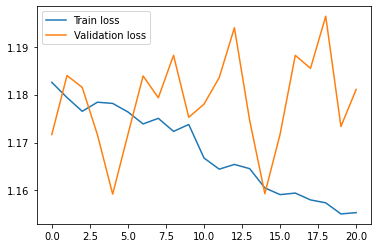

In [123]:
print('baseline AUPRC:',sum(y_train)/len(y_train))

#train_loader = torch.load('psychosis_prediction/train_loader.pth')
#val_loader = torch.load('psychosis_prediction/val_loader.pth')

n_epochs = 20
batch_size=batchsize
feature_size = train_mat_features.shape[1]

#for train_loader, val_loader in zip()
model = AttentionModel(hidden_size = 250, feature_size = feature_size)
#model = RNNModel(hidden_size = 6, feature_size = feature_size, seq_len = train_mat_features.shape[2])
parameters = model.parameters()
optimizer = torch.optim.Adam(parameters, lr=1e-3, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)


train_model(model, train_loader, val_loader, optimizer, n_epochs, device ,cv=0)
